In [1]:
import multiprocessing
import os
from re import A
from typing import ItemsView

from py import log
os.environ['PYTHONDONTWRITEBYTECODE'] = '1'
from xtquant import xttrader
from xtquant.xttrader import XtQuantTrader, XtQuantTraderCallback
from xtquant.xttype import StockAccount
from xtquant import xtconstant
import pandas_market_calendars as mcal
import pandas as pd
import akshare as ak

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
def plot(df, column):
    
    # 设置中文字体
    mpl.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体为 SimHei
    mpl.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

    # 假设这是你的DataFrame，其中包含收益

    # 绘制收益曲线
    # 将日期列转换为日期类型
    # df['date'] = pd.to_datetime(df['date'])

    # # 设置日期列为索引
    # df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    # 绘制收益曲线
    plt.figure(figsize=(10, 6))  # 设置图表大小
    plt.plot(df.index, df[column], label='Return')
    plt.title('收益曲线')
    plt.xlabel('日期')
    plt.ylabel('收益率')
    plt.legend()  # 显示图例
    plt.grid(True)  # 显示网格线

    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))

    plt.show()

d:\anaconda3\envs\python3.8\lib\site-packages\exchange_calendars\exchange_calendar.py:2345: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  align: pd.Timedelta | str = pd.Timedelta(1, "T"),


In [2]:
from xtquant import xtdatacenter as xtdc
xtdc.set_token("26e6009f4de3bfb2ae4b89763f255300e96d6912")

print('xtdc.init')
xtdc.init() # 初始化行情模块，加载合约数据，会需要大约十几秒的时间
print('done')

from xtquant import xtdata 

xtdc.init
done


In [3]:
import sys
sys.path.append(r"D:\workspace\TradeX\ezMoney")
from http_request import build_http_request
from data_class import category_rank_class
def get_ranked_category_infos(date_key, except_is_ppp = True, except_is_track = False, gap = 10):
    # build_http_request.check_user_alive()
    categoryRankList = category_rank_class.build_category_rank_sort_list(date_key)
    block_rank_list = []
    for item in categoryRankList:
        if item == None:
            continue
        if item.stockType == 'industry':
            isPpp = item.isPpp
            num = item.num
            numChange = item.numChange
            isTrack = item.isTrack
            stockCode = item.categoryCode
            r  = {
                'isPpp': isPpp,
                'num': num,
                'numChange': numChange,
                'isTrack': isTrack,
                'blockCode': stockCode
            }
            block_rank_list.append(r)
        if item.blockRankList == None:
            continue
        block_rank_list.extend(item.blockRankList)

    if except_is_ppp:
        block_rank_list = [item for item in block_rank_list if not item['isPpp']]
    if except_is_track:
        block_rank_list = [item for item in block_rank_list if not item['isTrack']]

    sorted_block_rank_list = sorted(block_rank_list, key=lambda x: (-x['num'], -x['numChange']))
    rank_dict = {}
    prev_num = None
    current_rank = 1

    for idx, item in enumerate(sorted_block_rank_list):
        code = item['blockCode']
        num = item['num']

        if idx == 0:
            # 第一个元素直接赋初始排名
            rank_dict[code] = current_rank
            prev_num = num
            continue

        delta = 0
        diff = prev_num - num

        # 判断差值规则
        if abs(diff) <= 0.0001:
            delta = 0
        else:
            if gap == 0:
                delta = 1
            else:
                if diff > gap:
                    delta = int(diff // gap) + 1
                else:
                    delta = 1
        current_rank += delta
        rank_dict[code] = current_rank
        prev_num = num
    return rank_dict

In [ ]:
from ezMoney import strategy


hd_pct = 0.001

# params = [
#               {
#         "filtered": True,
#         "fx_filtered": True,
#         "topn": 1,
#         "top_fx": 1,
#         "top_cx": 4,
#         "only_fx": False,
#         "enbale_industry": True,
#         "empty_priority": True
#       }
#         ]
strategy_name = '中位低吸'
days = 3
#胜率最高
params = [
              {
        "filtered": True,
        "fx_filtered": True,
        "topn": 1,
        "top_fx": 3,
        "top_cx": 15,
        "only_fx": True,
        "enbale_industry": True,
        "empty_priority": True
      }
        ]

# params = [
#               {
#         "filtered": True,
#         "fx_filtered": True,
#         "topn": 1,
#         "top_fx": 1,
#         "top_cx": 2,
#         "only_fx": False,
#         "enbale_industry": True,
#         "empty_priority": False
#       }
#         ]

filter_count = 0
filter_amount = 6000000
gap = 0
rank_filter = False

In [5]:
def get_first_tick_trade_amount(stock_code, datekey):
    import datetime
    import pandas as pd

    today = datetime.datetime.strptime(datekey, '%Y-%m-%d').date()

    time_0930 = datetime.time(9, 20, 0)

    dt_0930 = datetime.datetime.combine(today, time_0930)

    timestamp_0930 = dt_0930.timestamp()

    time_09305 = datetime.time(9, 26, 0)

    dt_09305 = datetime.datetime.combine(today, time_09305)

    timestamp_09305 = dt_09305.timestamp()

    tims = int(timestamp_0930*1000)

    tims5 = int(timestamp_09305*1000)
    import numpy as np
    n_data_key = datekey.replace('-', '')
    xtdata.download_history_data(stock_code, 'tick', n_data_key, n_data_key)
    all_tick_data = xtdata.get_market_data(stock_list=[stock_code], period='tick', start_time=n_data_key, end_time=n_data_key)

    # 假设 all_tick_data['000759.SZ'] 是 numpy.void 数组
    if isinstance(all_tick_data[stock_code], np.ndarray) and all_tick_data[stock_code].dtype.type is np.void:
        df = pd.DataFrame(all_tick_data[stock_code].tolist(), columns=all_tick_data[stock_code].dtype.names)
    else:
        raise

    filtered_df = df[(df['time'] >= tims) & (df['time'] <= tims5)]

    # 按 time 列升序排序
    sorted_df = filtered_df.sort_values(by='time')

    # 取 time 最小的行
    min_time_row = sorted_df.tail(1)

    amount = min_time_row['amount']

    if len(amount) == 1:
        real_amount = amount.item()
    else:
        raise Exception(f"{stock_code}-{datekey}")

    return real_amount

def get_real_open_price(stock_code, datekey):
    import datetime

    today = datetime.datetime.strptime(datekey, '%Y-%m-%d').date()

    time_0930 = datetime.time(9, 29, 0)

    dt_0930 = datetime.datetime.combine(today, time_0930)

    timestamp_0930 = dt_0930.timestamp()

    time_09305 = datetime.time(9, 30, 5)

    dt_09305 = datetime.datetime.combine(today, time_09305)

    timestamp_09305 = dt_09305.timestamp()

    tims = int(timestamp_0930*1000)

    tims5 = int(timestamp_09305*1000)
    import numpy as np
    n_data_key = datekey.replace('-', '')
    xtdata.download_history_data(stock_code, 'tick', n_data_key, n_data_key)
    all_tick_data = xtdata.get_market_data(stock_list=[stock_code], period='tick', start_time=n_data_key, end_time=n_data_key)

    # 假设 all_tick_data['000759.SZ'] 是 numpy.void 数组
    if isinstance(all_tick_data[stock_code], np.ndarray) and all_tick_data[stock_code].dtype.type is np.void:
        df = pd.DataFrame(all_tick_data[stock_code].tolist(), columns=all_tick_data[stock_code].dtype.names)
    else:
        raise

    filtered_df = df[(df['time'] >= tims) & (df['time'] <= tims5)]

    # 按 time 列升序排序
    sorted_df = filtered_df.sort_values(by='time')

    # 取 time 最小的行
    min_time_row = sorted_df.head(1)

    last_price = min_time_row['lastPrice']

    # 检查 Series 是否只有一个元素
    if len(last_price) == 1:
        last_price_real = last_price.item()
    else:
        raise Exception(f"{stock_code}-{datekey}")

    return last_price_real

In [ ]:
all_stocks = {}
all_stocks_info = xtdata.get_stock_list_in_sector('沪深A股')
for stock in all_stocks_info:
    if stock.startswith('60') or stock.startswith('00'):
        cde = stock.split('.')[0]
        all_stocks[cde] = stock

def group_filter_fx(group, filtered = True, fx_filtered = True, topn = 3, top_fx = 2, top_cx = 2, only_fx = False, enbale_industry= False, filter_amount = filter_amount, all_stocks = all_stocks):
    if filter_amount > 0:
        masks = []
        first_tick_amounts = []  # 存储每行的 first_tick_amount
        
        # 遍历每一行并计算值
        for _, row in group.iterrows():
            if row['stock_code'].split('.')[0] not in all_stocks:
                masks.append(False)
                first_tick_amounts.append(0)
                continue
            stock_code = all_stocks[row['stock_code'].split('.')[0]]
            date_key = row['date_key']
                
            # 计算 first_tick_amount
            first_tick_amount = get_first_tick_trade_amount(stock_code, date_key)
            first_tick_amounts.append(first_tick_amount)  # 记录值
            if first_tick_amount > filter_amount:
                masks.append(True)
            else:
                print(f"过滤股票 {stock_code} 日期 {date_key} 过滤原因： first_tick_amount {first_tick_amount}")
                masks.append(False)
                global filter_count
                filter_count = filter_count + 1
            # 生成过滤掩码
        
        # 将 first_tick_amount 添加到原始分组中
        group = group.copy()  # 避免 SettingWithCopyWarning
        group['first_tick_amount'] = first_tick_amounts
        
        # 应用过滤
        group = group[masks]
            
    if not filtered:
        valid_rows = group[(group['open_price'] > 0) & (group['next_day_open_price'] > 0) & (group['stock_rank'] <= topn) & (group['next_day_close_price'] > 0)]
        if len(valid_rows) > 0:
            valid_rows['return'] = valid_rows['next_day_open_price'] / valid_rows['open_price'] - 1
            valid_rows['real_return'] = valid_rows['return'] - hd_pct
            valid_rows['close_return'] = valid_rows['next_day_close_price'] / valid_rows['open_price'] - 1
            valid_rows['close_real_return'] = valid_rows['close_return'] - hd_pct
            avg_value = valid_rows['return'].mean()
            close_avg_value = valid_rows['close_return'].mean()
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if len(rank_one_row) > 0:
                # 将平均值赋给 rank 为 1 的行的指定列
                rank_one_row['return'] = avg_value
                rank_one_row['real_return'] = avg_value - hd_pct
                rank_one_row['close_return'] = close_avg_value
                rank_one_row['close_real_return'] = close_avg_value - hd_pct
                return rank_one_row
        else:
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if len(rank_one_row) > 0:
                rank_one_row['return'] = -10
                rank_one_row['real_return'] = -10
                rank_one_row['close_return'] = -10
                rank_one_row['close_real_return'] = -10
                return rank_one_row
    else:
        if fx_filtered:
            min_category_rank = group['max_block_category_rank'].min()
            
            industry_rank_one_row = group[group['max_industry_code_rank'] == 1].copy()
            if not industry_rank_one_row.empty and len(industry_rank_one_row) == 1 and enbale_industry:
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            elif not industry_rank_one_row.empty and len(industry_rank_one_row) > 1 and enbale_industry:
                industry_rank_one_row = industry_rank_one_row[industry_rank_one_row['stock_rank'] == industry_rank_one_row['stock_rank'].min()]
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row

            if min_category_rank > top_fx:
                if only_fx:
                    return group[group['max_block_category_rank'] < min_category_rank]
                rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                if len(rank_one_row) > 0:
                    rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                    rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row
            else:
                category_filtered = group[(group['max_block_category_rank'] <= top_fx) & ((group['max_block_code_rank'] <= top_cx) | (group['max_industry_code_rank'] <= top_cx))]
                if len(category_filtered) == 0:
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row

                result = category_filtered[category_filtered['max_block_code_rank'] == category_filtered['max_block_code_rank'].min()]
                if len(result) > 1:
                    result = result[result['stock_rank'] == result['stock_rank'].min()]
                result['return'] = result['next_day_open_price'] / result['open_price'] - 1
                result['real_return'] = result['return'] - hd_pct
                result['close_return'] = result['next_day_close_price'] / result['open_price'] - 1
                result['close_real_return'] = result['close_return'] - hd_pct
                return result
        else:
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if not rank_one_row.empty and len(rank_one_row) > 0:
                rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
            return rank_one_row



def group_filter(group, filtered = True, fx_filtered = True, topn = 3, top_fx = 2, top_cx = 2, only_fx = False, enbale_industry= False, filter_amount = filter_amount, all_stocks = all_stocks):
    if filter_amount > 0:
        masks = []
        first_tick_amounts = []  # 存储每行的 first_tick_amount
        
        # 遍历每一行并计算值
        for _, row in group.iterrows():
            stock_code = all_stocks[row['stock_code'].split('.')[0]]
            date_key = row['date_key']
            if row['stock_code'].split('.')[0] not in all_stocks:
                masks.append(False)
                first_tick_amounts.append(0)
                continue
            # 计算 first_tick_amount
            first_tick_amount = get_first_tick_trade_amount(stock_code, date_key)
            first_tick_amounts.append(first_tick_amount)  # 记录值
            if first_tick_amount > filter_amount:
                masks.append(True)
            else:
                print(f"过滤股票 {stock_code} 日期 {date_key} 过滤原因： first_tick_amount {first_tick_amount}")
                masks.append(False)
                global filter_count
                filter_count = filter_count + 1
            # 生成过滤掩码
        
        # 将 first_tick_amount 添加到原始分组中
        group = group.copy()  # 避免 SettingWithCopyWarning
        group['first_tick_amount'] = first_tick_amounts
        
        # 应用过滤
        group = group[masks]
    if not filtered:
        valid_rows = group[(group['open_price'] > 0) & (group['next_day_open_price'] > 0) & (group['stock_rank'] <= topn) & (group['next_day_close_price'] > 0)]
        if len(valid_rows) > 0:
            valid_rows['return'] = valid_rows['next_day_open_price'] / valid_rows['open_price'] - 1
            valid_rows['real_return'] = valid_rows['return'] - hd_pct
            valid_rows['close_return'] = valid_rows['next_day_close_price'] / valid_rows['open_price'] - 1
            valid_rows['close_real_return'] = valid_rows['close_return'] - hd_pct
            avg_value = valid_rows['return'].mean()
            close_avg_value = valid_rows['close_return'].mean()
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if len(rank_one_row) > 0:
                # 将平均值赋给 rank 为 1 的行的指定列
                rank_one_row['return'] = avg_value
                rank_one_row['real_return'] = avg_value - hd_pct
                rank_one_row['close_return'] = close_avg_value
                rank_one_row['close_real_return'] = close_avg_value - hd_pct
                return rank_one_row
        else:
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if len(rank_one_row) > 0:
                rank_one_row['return'] = -10
                rank_one_row['real_return'] = -10
                rank_one_row['close_return'] = -10
                rank_one_row['close_real_return'] = -10
                return rank_one_row
    else:
        if fx_filtered:
            min_category_rank = group['max_block_category_rank'].min()

            industry_rank_one_row = group[group['max_industry_code_rank'] == 1].copy()
            if not industry_rank_one_row.empty and len(industry_rank_one_row) == 1 and enbale_industry:
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            elif not industry_rank_one_row.empty and len(industry_rank_one_row) > 1 and enbale_industry:
                industry_rank_one_row = industry_rank_one_row[industry_rank_one_row['stock_rank'] == industry_rank_one_row['stock_rank'].min()]
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            
            if min_category_rank > top_fx:
                if only_fx:
                    return group[group['max_block_category_rank'] < min_category_rank]
                rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                if len(rank_one_row) > 0:
                    rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                    rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row
            elif min_category_rank < 0:
                category_filtered = group[(group['max_block_category_rank'] > 0) & (group['max_block_category_rank'] <= top_fx) & (((group['max_block_code_rank'] <= top_cx) & (group['max_block_code_rank'] > 0)) | ((group['max_industry_code_rank'] <= top_cx) & (group['max_industry_code_rank'] > 0)))]
                if not category_filtered.empty and len(category_filtered) > 0:
                    category_filtered = category_filtered[category_filtered['stock_rank'] == category_filtered['stock_rank'].min()]
                    category_filtered['return'] = category_filtered['next_day_open_price'] / category_filtered['open_price'] - 1
                    category_filtered['real_return'] = category_filtered['return'] - hd_pct
                    category_filtered['close_return'] = category_filtered['next_day_close_price'] / category_filtered['open_price'] - 1
                    category_filtered['close_real_return'] = category_filtered['close_return'] - hd_pct
                    return category_filtered
                else:
                    rank_one_row = group[group['max_block_category_rank'] == min_category_rank]
                    if len(rank_one_row) > 0:
                        rank_one_row = rank_one_row[rank_one_row['stock_rank'] == rank_one_row['stock_rank'].min()].copy()
                        if not rank_one_row.empty and len(rank_one_row) > 0:
                            rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                            rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                            rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                            rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                            return rank_one_row
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                        return rank_one_row
                    else:
                        raise Exception("No data.")
            else:
                result = group[(group['max_block_category_rank'] > 0) & (group['max_block_category_rank'] <= top_fx) & (((group['max_block_code_rank'] <= top_cx) & (group['max_block_code_rank'] > 0)) | ((group['max_industry_code_rank'] <= top_cx) & (group['max_industry_code_rank'] > 0)))]
                
                if result.empty or len(result) < 1:
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                        return rank_one_row
                if len(result) > 1:
                    result = result[result['stock_rank'] == result['stock_rank'].min()]
                result['return'] = result['next_day_open_price'] / result['open_price'] - 1
                result['real_return'] = result['return'] - hd_pct
                result['close_return'] = result['next_day_close_price'] / result['open_price'] - 1
                result['close_real_return'] = result['close_return'] - hd_pct
                return result
        else:
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if not rank_one_row.empty and len(rank_one_row) > 0:
                rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
            return rank_one_row


***** xtdata连接成功 *****
服务信息: {'tag': 'xtquant', 'version': '1.0'}
服务地址: 127.0.0.1:58609
数据路径: d:\workspace\TradeX\notebook\data\datadir
设置xtdata.enable_hello = False可隐藏此消息



In [7]:
param0 = params[0]
empty_priority = param0['empty_priority']
del param0['empty_priority']
if empty_priority:
    filter_func = group_filter_fx
else:
    filter_func = group_filter

In [ ]:
import sqlite3
# months = ['202502']
months = ['202409', '202410', '202411', '202412', '202501', '202502', '202503']
# months = ['202409', '202410']
combined_df = pd.DataFrame()
for month in months:
    conn = sqlite3.connect('D:\workspace\TradeX\ezMoney\sqlite_db\strategy_data.db')
    db_name = 'strategy_data_aftermarket_%s' % month
    query = "select * from %s where (sub_strategy_name = %s) and stock_rank <= %s " % (db_name, strategy_name, days)
    df = pd.read_sql_query(query, conn)
    combined_df = pd.concat([combined_df, df], axis=0)
combined_df = combined_df.reset_index(drop=True)
combined_df

,id,date_key,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,...,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,env_json_info,block_category_info,created_at
0,922,2024-09-02,低吸,低位孕线低吸,000759.XSHE,中百集团,1,"000012.BKDL,000024.BKDL,000026.BKDL,000018.BKD...","885951.DDBK,886021.DDBK,885812.DDBK,885901.DDB...","980374.ZHBK,980345.ZHBK",...,低位孕线低吸,21.00,41.76,23,-45.08,1.50,42,"{""9A0001"": {""realShortLineScore"": 23.04, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-15 17:42:15
1,995,2024-09-04,低吸,低位孕线低吸,002189.XSHE,中光学,1,"000012.BKDL,000008.BKDL,000014.BKDL,000010.BKD...","886021.DDBK,885595.DDBK,885545.DDBK,885700.DDB...","980363.ZHBK,980357.ZHBK",...,低位孕线低吸,19.04,2.91,14,-47.76,1.94,41,"{""9A0001"": {""realShortLineScore"": 26.55, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-15 17:44:23
2,996,2024-09-04,低吸,低位孕线低吸,000034.XSHE,神州数码,2,"000012.BKDL,000003.BKDL,000038.BKDL,000026.BKD...","885459.DDBK,886048.DDBK,885757.DDBK,885957.DDB...","980345.ZHBK,980366.ZHBK",...,低位孕线低吸,19.04,2.91,14,-47.76,1.94,41,"{""9A0001"": {""realShortLineScore"": 26.55, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-15 17:44:23
3,1041,2024-09-05,低吸,低位孕线低吸,600503.XSHG,华丽家族,1,"000015.BKDL,000001.BKDL,000033.BKDL","885517.DDBK,885835.DDBK,885355.DDBK",980358.ZHBK,...,低位孕线低吸,-9.74,-28.78,31,-57.74,-8.20,41,"{""9A0001"": {""realShortLineScore"": -12.1, ""real...","{""000003.BKDL"": {""categoryCode"": ""000003.BKDL""...",2025-02-15 17:45:27
4,1089,2024-09-06,低吸,低位孕线低吸,002571.XSHE,德力股份,1,"000012.BKDL,000018.BKDL,000035.BKDL,000010.BKD...","885910.DDBK,885413.DDBK,885431.DDBK,885835.DDB...",980373.ZHBK,...,低位孕线低吸,-68.93,-59.19,61,-77.19,-3.71,51,"{""9A0001"": {""realShortLineScore"": -22.6, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-15 17:46:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,1321,2025-03-07,低吸,低位孕线低吸,600280.XSHG,中央商场,2,000010.BKDL,"885420.DDBK,885951.DDBK,885784.DDBK","980374.ZHBK,980345.ZHBK",...,低位孕线低吸,58.99,132.39,24,94.00,19.49,2,"{""9A0001"": {""realShortLineScore"": 57.92, ""real...","{""000003.BKDL"": {""categoryCode"": ""000003.BKDL""...",2025-03-10 08:01:27
133,1488,2025-03-10,低吸,低位孕线低吸,000700.XSHE,模塑科技,1,"000038.BKDL,000014.BKDL,000015.BKDL,000027.BKD...","885984.DDBK,885785.DDBK,885490.DDBK,885694.DDB...",980372.ZHBK,...,低位孕线低吸,17.55,-29.06,33,73.56,-17.20,3,"{""9A0001"": {""realShortLineScore"": 58.85, ""real...","{""000033.BKDL"": {""categoryCode"": ""000033.BKDL""...",2025-03-11 08:01:33
134,1489,2025-03-10,低吸,低位孕线低吸,000779.XSHE,甘咨询,2,"000003.BKDL,000008.BKDL,000024.BKDL,000035.BKD...","885993.DDBK,886021.DDBK,885957.DDBK,885962.DDB...","980338.ZHBK,980343.ZHBK",...,低位孕线低吸,17.55,-29.06,33,73.56,-17.20,3,"{""9A0001"": {""realShortLineScore"": 58.85, ""real...","{""000033.BKDL"": {""categoryCode"": ""000033.BKDL""...",2025-03-11 08:01:33
135,1701,2025-03-12,低吸,低位孕线低吸,002662.XSHE,京威股份,1,"000038.BKDL,000036.BKDL,000035.BKDL,000011.BKD...","885984.DDBK,885694.DDBK,885710.DDBK,885467.DDB...",980372.ZHBK,...,低位孕线低吸,35.87,9.16,24,73.50,-1.62,3,"{""9C0001"": {""realShortLineScore"": 58.05, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-03-12 08:02:25


In [9]:
if rank_filter:
    for idx, row in combined_df.iterrows():
        block_category = row['block_category']
        block_codes = row['block_codes']
        industry_code = row['industry_code']
        date_key = row['date_key']
        ranked_block_dict = get_ranked_category_infos(date_key, gap = gap)
        min_rank = 100
        if not block_codes:
            continue
        else:
            for block_code in block_codes.split(','):
                if block_code in ranked_block_dict:
                    rank_this = ranked_block_dict[block_code]
                    min_rank = min(min_rank, rank_this)
        if not industry_code:
            combined_df.loc[idx, 'max_block_code_rank'] = min_rank
            continue
        else:
            i_min_rank = 100
            for i_code in industry_code.split(','):
                if i_code in ranked_block_dict:
                    rank_this = ranked_block_dict[i_code]
                    min_rank = min(min_rank, rank_this)
                    i_min_rank = min(i_min_rank, rank_this)
                    combined_df.loc[idx, 'max_industry_code_rank'] = i_min_rank
            combined_df.loc[idx, 'max_block_code_rank'] = min_rank


In [10]:
combined_df = combined_df.reset_index(drop=True)

In [11]:
combined_df = combined_df.drop(['env_json_info', 'block_category_info'], axis=1)
combined_df = combined_df[combined_df['strategy_name'] == '低吸']

In [12]:
pd.set_option('display.max_columns', None)
combined_df.tail(10)

,id,date_key,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at
127,721,2025-03-05,低吸,低位孕线低吸,603398.XSHG,沐邦高科,1,"000021.BKDL,000023.BKDL,000035.BKDL,000010.BKD...","885520.DDBK,885729.DDBK,885539.DDBK,886007.DDB...","980474.ZHBK,980373.ZHBK",7,27,28,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0.0,79.68,265.25,0.0,-3.31,17.80,18.17,-1.0,18.17,18.83,-1.0,-1.0,-1.0,-1.0,0,0,9G0086,低位孕线低吸,-70.97,-17.17,42,79.86,-7.58,2,2025-03-06 08:01:25
128,722,2025-03-05,低吸,低位孕线低吸,600391.XSHG,航发科技,2,"000018.BKDL,000037.BKDL,000017.BKDL,000013.BKD...","885520.DDBK,886021.DDBK,885795.DDBK,885595.DDB...",980363.ZHBK,3,6,39,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,67.31,243.78,0.0,-2.60,20.20,20.40,-1.0,20.41,20.25,-1.0,-1.0,-1.0,-1.0,0,0,9G0086,低位孕线低吸,-70.97,-17.17,42,79.86,-7.58,2,2025-03-06 08:01:25
129,971,2025-03-06,低吸,低位孕线低吸,002796.XSHE,世嘉科技,1,"000035.BKDL,000009.BKDL,000013.BKDL,000025.BKDL","885921.DDBK,886037.DDBK,885539.DDBK,885700.DDB...","980365.ZHBK,980376.ZHBK",9,19,23,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,111.65,312.63,0.0,-0.94,12.64,12.97,-1.0,12.97,13.20,-1.0,-1.0,-1.0,-1.0,0,0,9G0086,低位孕线低吸,-80.18,-6.95,47,71.29,-7.54,4,2025-03-07 03:13:10
130,972,2025-03-06,低吸,低位孕线低吸,002307.XSHE,北新路桥,2,"000038.BKDL,000008.BKDL,000023.BKDL,000018.BKD...","886021.DDBK,885694.DDBK,885345.DDBK,885991.DDB...",980338.ZHBK,12,4,61,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,93.21,260.15,0.0,-0.45,4.42,4.35,-1.0,4.37,4.42,-1.0,-1.0,-1.0,-1.0,0,0,9G0086,低位孕线低吸,-80.18,-6.95,47,71.29,-7.54,4,2025-03-07 03:13:10
131,1320,2025-03-07,低吸,低位孕线低吸,600318.XSHG,新力金融,1,"000023.BKDL,000010.BKDL,000015.BKDL","885740.DDBK,886016.DDBK,885456.DDBK","980360.ZHBK,980341.ZHBK",8,40,100,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,2,0.0,76.18,201.43,0.0,-2.38,8.60,8.40,-1.0,8.40,8.45,-1.0,-1.0,-1.0,-1.0,0,0,9G0086,低位孕线低吸,58.99,132.39,24,94.00,19.49,2,2025-03-10 08:01:27
132,1321,2025-03-07,低吸,低位孕线低吸,600280.XSHG,中央商场,2,000010.BKDL,"885420.DDBK,885951.DDBK,885784.DDBK","980374.ZHBK,980345.ZHBK",13,41,53,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,37.76,182.61,0.0,-2.04,3.85,3.77,-1.0,3.77,3.74,-1.0,-1.0,-1.0,-1.0,0,0,9G0086,低位孕线低吸,58.99,132.39,24,94.00,19.49,2,2025-03-10 08:01:27
133,1488,2025-03-10,低吸,低位孕线低吸,000700.XSHE,模塑科技,1,"000038.BKDL,000014.BKDL,000015.BKDL,000027.BKD...","885984.DDBK,885785.DDBK,885490.DDBK,885694.DDB...",980372.ZHBK,2,1,28,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,187.84,373.56,0.0,-1.13,7.86,8.05,-1.0,7.89,8.35,-1.0,-1.0,-1.0,-1.0,0,0,9G0086,低位孕线低吸,17.55,-29.06,33,73.56,-17.20,3,2025-03-11 08:01:33
134,1489,2025-03-10,低吸,低位孕线低吸,000779.XSHE,甘咨询,2,"000003.BKDL,000008.BKDL,000024.BKDL,000035.BKD...","885993.DDBK,886021.DDBK,885957.DDBK,885962.DDB...","980338.ZHBK,980343.ZHBK",2,9,38,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,58.49,211.86,0.0,-2.38,9.86,9.83,-1.0,9.90,10.18,-1.0,-1.0,-1.0,-1.0,0,0,9G0086,低位孕线低吸,17.55,-29.06,33,73.56,-17.20,3,2025-03-11 08:01:33
135,1701,2025-03-12,低吸,低位孕线低吸,002662.XSHE,京威股份,1,"000038.BKDL,000036.BKDL,000035.BKDL,000011.BKD...","885984.DDBK,885694.DDBK,885710.DDBK,885467.DDB...",980372.ZHBK,1,2,14,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,61.02,232.13,0.0,-0.73,-1.00,-1.00,-1.0,-1.00,-1.00,-1.0,-1.0,-1.0,-1.0,0,0,9G0086,低位孕线低吸,35.87,9.16,24,73.50,-1.62,3,202

In [13]:

combined_df = combined_df.groupby(['date_key', 'strategy_name', 'sub_strategy_name']).apply(filter_func, **param0).reset_index(drop=True)

# 将索引设置为 date_key 列
combined_df = combined_df.set_index('date_key')

# 对索引进行排序
combined_df = combined_df.sort_index()


combined_df

过滤股票 600503.SH 日期 2024-09-05 过滤原因： first_tick_amount 5910660.0
过滤股票 002571.SZ 日期 2024-09-06 过滤原因： first_tick_amount 3747491.0
过滤股票 003011.SZ 日期 2024-09-25 过滤原因： first_tick_amount 5423209.0
过滤股票 002652.SZ 日期 2024-09-30 过滤原因： first_tick_amount 5676876.0
过滤股票 002982.SZ 日期 2024-10-15 过滤原因： first_tick_amount 4071855.0
过滤股票 002620.SZ 日期 2024-10-23 过滤原因： first_tick_amount 3839400.0
过滤股票 002620.SZ 日期 2024-10-24 过滤原因： first_tick_amount 2300400.0
过滤股票 603488.SH 日期 2024-10-25 过滤原因： first_tick_amount 4856698.0
过滤股票 003007.SZ 日期 2024-10-28 过滤原因： first_tick_amount 5302220.0
过滤股票 002553.SZ 日期 2024-10-30 过滤原因： first_tick_amount 5784450.0
过滤股票 603082.SH 日期 2024-11-05 过滤原因： first_tick_amount 3575879.0
过滤股票 603029.SH 日期 2024-11-11 过滤原因： first_tick_amount 5375621.0
过滤股票 600243.SH 日期 2024-11-11 过滤原因： first_tick_amount 4813992.0
过滤股票 605001.SH 日期 2024-11-12 过滤原因： first_tick_amount 5060880.0
过滤股票 001255.SZ 日期 2024-11-14 过滤原因： first_tick_amount 4533360.0
过滤股票 001387.SZ 日期 2024-11-28 过滤原因： first_tick_amount 20

C:\Users\Administrator\AppData\Local\Temp\ipykernel_14296\2790183003.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_df = combined_df.groupby(['date_key', 'strategy_name', 'sub_strategy_name']).apply(filter_func, **param0).reset_index(drop=True)


,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,first_tick_amount,return,real_return,close_return,close_real_return
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-09-04,995,低吸,低位孕线低吸,002189.XSHE,中光学,1,"000012.BKDL,000008.BKDL,000014.BKDL,000010.BKD...","886021.DDBK,885595.DDBK,885545.DDBK,885700.DDB...","980363.ZHBK,980357.ZHBK",1,1,2,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,96.68,256.87,0.0,-5.68,16.10,16.21,-1.0,15.90,17.83,-1.0,-1.0,-1.0,-1.0,0,0,9G0086,低位孕线低吸,19.04,2.91,14,-47.76,1.94,41,2025-02-15 17:44:23,17803380.0,-0.012422,-0.013422,0.107453,0.106453
2024-09-10,1186,低吸,低位孕线低吸,003043.XSHE,华亚智能,1,"000038.BKDL,000018.BKDL,000035.BKDL,000031.BKD...","886054.DDBK,885694.DDBK,885929.DDBK,885770.DDB...","980365.ZHBK,980357.ZHBK",1,3,25,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,106.58,238.06,0.0,-3.37,38.70,39.32,-1.0,39.20,38.66,-1.0,-1.0,-1.0,-1.0,0,0,9G0086,低位孕线低吸,-13.36,68.24,48,-43.61,-2.57,40,2025-02-15 17:48:40,7383960.0,0.012920,0.011920,-0.001034,-0.002034
2024-09-13,1298,低吸,低位孕线低吸,603626.XSHG,科森科技,2,"000012.BKDL,000014.BKDL,000035.BKDL,000010.BKD...","885899.DDBK,885467.DDBK,885517.DDBK,885771.DDB...","980365.ZHBK,980357.ZHBK",1,3,6,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,137.86,168.75,0.0,-5.70,8.60,8.21,-1.0,8.38,8.18,-1.0,-1.0,-1.0,-1.0,0,0,9G0086,低位孕线低吸,63.19,35.05,8,-9.49,-4.35,32,2025-02-15 17:51:50,34110180.0,-0.025581,-0.026581,-0.048837,-0.049837
2024-09-18,1347,低吸,低位孕线低吸,603421.XSHG,鼎信通讯,2,"000035.BKDL,000031.BKDL,000027.BKDL,000037.BKD...","885520.DDBK,885312.DDBK,885925.DDBK,886004.DDB...","980753.ZHBK,980376.ZHBK",1,4,28,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,48.14,160.36,0.0,-0.20,5.03,5.54,-1.0,5.40,5.56,-1.0,-1.0,-1.0,-1.0,0,0,9G0086,低位孕线低吸,28.79,-34.40,10,-20.19,-12.17,34,2025-02-15 17:52:53,8616390.0,0.073559,0.072559,0.105368,0.104368
2024-09-20,1425,低吸,低位孕线低吸,600838.XSHG,上海九百,1,"000012.BKDL,000023.BKDL,000010.BKDL,000015.BKD...","885869.DDBK,885620.DDBK,885788.DDBK,886021.DDB...","980374.ZHBK,980345.ZHBK",2,3,45,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,175.18,263.41,0.0,-2.99,6.82,6.95,-1.0,6.73,6.56,-1.0,-1.0,-1.0,-1.0,0,0,9G0086,低位孕线低吸,40.17,-0.17,21,-25.24,-22.03,49,2025-02-15 17:55:04,15909703.0,-0.013196,-0.014196,-0.038123,-0.039123
2024-09-23,1456,低吸,低位孕线低吸,000815.XSHE,美利云,1,"000003.BKDL,000038.BKDL,000014.BKDL,000035.BKD...","885785.DDBK,885936.DDBK,886021.DDBK,885957.DDB...","980366.ZHBK,980373.ZHBK",3,1,9,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,65.47,175.77,0.0,-2.64,8.10,8.18,-1.0,8.19,8.49,-1.0,-1.0,-1.0,-1.0,0,0,9G0086,低位孕线低吸,45.72,5.55,29,0.99,6.43,41,2025-02-15 17:56:06,18354600.0,0.011111,0.010111,0.048148,0.047148
2024-09-24,1471,低吸,低位孕线低吸,002607.XSHE,中公教育,1,"000012.BKDL,000038.BKDL,000010.BKDL,000019.BKD...","885586.DDBK,885694.DDBK,885761.DDBK,885745.DDB...","980473.ZHBK,980355.ZHBK,980340.ZHBK",2,2,34,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,54.62,151.45,0.0,-1.87,2.10,2.29,-1.0,2.23,2.21,-1.0,-1.0,-1.0,-1.0,0,0,9G0086,低位孕线低吸,56.52,10.80,27,8.39,0.56,28,2025-02-15 17:57:08,33323220.0,0.061905,0.060905,0.052381,0.051381
2024-09-27,1615,低吸,低位孕线低吸,600318.XSHG,新力金融,1,"000023.BKDL,000010.BKDL,000015.BKDL","885740.DDBK,886016.DDBK,885456.DDBK","980360.ZHBK,980341

In [14]:
from xtquant import xtdata
import time
import pandas as pd

all_stocks = {}
all_stocks_info = xtdata.get_stock_list_in_sector('沪深A股')
for stock in all_stocks_info:
    if stock.startswith('60') or stock.startswith('00'):
        cde = stock.split('.')[0]
        all_stocks[cde] = stock
for i in range(1, 11):
    combined_df[f'close_{i}'] = -1
    combined_df[f'low_{i}'] = -1
combined_df['real_open'] = -1
for date_key, row in combined_df.iterrows():
    stock_code = row['stock_code']
    stock_code = all_stocks[stock_code.split('.')[0]]
    n_data_key = date_key
    if '-' in n_data_key:
        n_data_key = n_data_key.replace('-', '')
    # xtdata.download_history_data(stock_code, '1m', n_data_key, n_data_key)
    # all_data = xtdata.get_market_data(stock_list=[stock_code], period='1m', start_time=n_data_key, end_time=n_data_key)

    # df = pd.DataFrame()
    # for key in all_data.keys():
    #     ndf = all_data[key].T
    #     ndf = ndf.sort_index()
    #     ndf.columns = [key]
    #     df = pd.concat([df, ndf], axis=1)
    
    # i = 1
    # for idx, rrow in df[1:11].iterrows():
    #     combined_df.loc[date_key, f'close_{i}'] = rrow['close']
    #     combined_df.loc[date_key, f'low_{i}'] = rrow['low']
    #     i += 1
    real_open_price = get_real_open_price(stock_code, date_key)
    combined_df.loc[date_key, 'real_open'] = real_open_price

C:\Users\Administrator\AppData\Local\Temp\ipykernel_14296\1308428503.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '16.24' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_df.loc[date_key, 'real_open'] = real_open_price


In [15]:
combined_df[['open_price', 'next_day_close_price', 'low_1', 'low_2', 'low_3', 'low_4', 'low_5', 'low_6', 'low_7', 'low_8', 'low_9', 'low_10']]

,open_price,next_day_close_price,low_1,low_2,low_3,low_4,low_5,low_6,low_7,low_8,low_9,low_10
date_key,,,,,,,,,,,,
2024-09-04,16.10,17.83,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-09-10,38.70,38.66,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-09-13,8.60,8.18,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-09-18,5.03,5.56,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-09-20,6.82,6.56,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-09-23,8.10,8.49,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-09-24,2.10,2.21,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-09-27,7.50,8.40,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-09-30,7.38,8.86,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [35]:
# combined_df['avg_close'] = 0
# for i in range(1, 11):
#     combined_df['avg_close'] += combined_df['close_%s' % i]
# combined_df['avg_close'] = combined_df['avg_close'] / 10
dwndx = combined_df[combined_df['open_price'] > 0]
ddwndx = dwndx.tail(10)

In [36]:
len(ddwndx)

10

In [37]:
def caculate_returns(returns_df, row, _print = False):
    r = {}
    cumulative_returns = (1 + returns_df[row]).cumprod()

    # 计算最大回撤
    cumulative_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()

    # 计算夏普比率
    risk_free_rate = 0.0  # 假设无风险利率为0
    sharpe_ratio = (returns_df[row].mean() - risk_free_rate) / returns_df[row].std()

    # 计算总收益率
    total_return = cumulative_returns.iloc[-1] - 1

    # 计算波动率
    volatility = returns_df[row].std()

    # 计算总盈亏
    total_profit_loss = cumulative_returns.iloc[-1] - cumulative_returns.iloc[0]

    # 计算成功次数、胜率、平均盈利、平均亏损、最大盈利、最大亏损以及盈亏比
    profitable_trades = returns_df[row][returns_df[row] > 0].count()
    losing_trades = returns_df[row][returns_df[row] < 0].count()
    win_rate = profitable_trades / (profitable_trades + losing_trades) if (profitable_trades + losing_trades) > 0 else 0
    average_profit = returns_df[row][returns_df[row] > 0].mean() if profitable_trades > 0 else 0
    average_loss = returns_df[row][returns_df[row] < 0].mean() if losing_trades > 0 else 0
    max_profit = returns_df[row].max()
    max_loss = returns_df[row].min()
    total_trades = profitable_trades + losing_trades
    total_times = returns_df[row].count()
    trade_pct = total_times / total_trades
    profit_loss_ratio = average_profit / abs(average_loss) if average_loss != 0 else 0
    kelly_fraction = win_rate - ((1 - win_rate) / profit_loss_ratio) if profit_loss_ratio != 0 else 0
    return_per_day = total_return / total_times
    year_return = return_per_day * 240

    r['最大回撤'] =  max_drawdown
    r['夏普比率'] =  sharpe_ratio
    r['总收益率'] =  total_return
    r['波动率'] = volatility
    r['年化收益率'] = year_return
    r['总盈亏'] = total_profit_loss
    r['成功次数'] = profitable_trades
    r['失败次数'] = losing_trades
    r['总天数'] = total_times
    r['总交易次数'] = total_trades
    r['交易频率'] = trade_pct
    r['胜率'] = win_rate
    r['平均盈利'] = average_profit
    r['平均亏损'] = average_loss
    r['最大盈利'] = max_profit
    r['最大亏损'] = max_loss
    r['盈亏比'] = profit_loss_ratio
    r['凯利公式最佳仓位'] = kelly_fraction
    if _print:
        print(f"最大回撤: {max_drawdown:.2%}")
        print(f"夏普比率: {sharpe_ratio:.2f}")
        print(f"总收益率: {total_return:.2%}")
        print(f"年化收益率: {year_return:.2%}")
        print(f"波动率: {volatility:.2%}")
        print(f"总盈亏: {total_profit_loss:.2%}")
        print(f"成功次数: {profitable_trades}")
        print(f"失败次数: {losing_trades}")
        print(f"总天数: {total_times}")
        print(f"总交易次数: {total_trades}")
        print(f"交易频率: {trade_pct:.2%}")
        print(f"胜率: {win_rate:.2%}")
        print(f"平均盈利: {average_profit:.2%}")
        print(f"平均亏损: {average_loss:.2%}")
        print(f"最大盈利: {max_profit:.2%}")
        print(f"最大亏损: {max_loss:.2%}")
        print(f"盈亏比: {profit_loss_ratio:.2f}")
        print(f"凯利公式最佳仓位: {kelly_fraction:.2%}")

    return r

In [38]:

ddwndx['r_return'] = ddwndx['next_day_open_price']/ddwndx['real_open'] - 1
ddwndx['r_return'] = ddwndx['r_return']-0.001
ddwndx['cumulative_returns'] = (1 + ddwndx['r_return']).cumprod()
print("return:")
caculate_returns(ddwndx, 'r_return', _print=True)
print('-----------------------------------------------------')

return:
最大回撤: -10.39%
夏普比率: 0.25
总收益率: 15.43%
年化收益率: 370.23%
波动率: 6.45%
总盈亏: 10.12%
成功次数: 7
失败次数: 3
总天数: 10
总交易次数: 10
交易频率: 100.00%
胜率: 70.00%
平均盈利: 3.81%
平均亏损: -3.49%
最大盈利: 16.39%
最大亏损: -9.73%
盈亏比: 1.09
凯利公式最佳仓位: 42.59%
-----------------------------------------------------


C:\Users\Administrator\AppData\Local\Temp\ipykernel_14296\3195836342.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ddwndx['r_return'] = ddwndx['next_day_open_price']/ddwndx['real_open'] - 1
C:\Users\Administrator\AppData\Local\Temp\ipykernel_14296\3195836342.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ddwndx['r_return'] = ddwndx['r_return']-0.001
C:\Users\Administrator\AppData\Local\Temp\ipykernel_14296\3195836342.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [39]:
ddwndx.tail(20)

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,r_return,cumulative_returns
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-02-06,2310,低吸,低位孕线低吸,002406.XSHE,远东传动,1,"000026.BKDL,000006.BKDL,000027.BKDL,000013.BKD...","885743.DDBK,885806.DDBK,885517.DDBK,885783.DDB...",980372.ZHBK,3,1,32,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,28.50,158.60,0.0,-1.38,6.45,6.85,-1.0,6.82,7.03,-1.0,-1.0,-1.0,-1.0,0,0,9G0086,低位孕线低吸,71.37,-1.98,4,102.80,-11.56,2,2025-02-28 17:18:47,7853520.0,0.057364,0.056364,0.089922,0.088922,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,6.47,0.053096,1.053096
2025-02-07,2365,低吸,低位孕线低吸,002579.XSHE,中京电子,2,"000015.BKDL,000019.BKDL,000034.BKDL,000013.BKD...","886042.DDBK,885875.DDBK,886009.DDBK,886070.DDB...",980357.ZHBK,1,1,14,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,93.10,286.69,0.0,-1.49,8.62,8.74,-1.0,8.76,8.81,-1.0,-1.0,-1.0,-1.0,0,0,9G0086,低位孕线低吸,89.42,-3.49,4,113.24,-5.90,2,2025-02-28 17:19:40,18323542.0,0.016241,0.015241,0.022042,0.021042,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,8.71,0.004741,1.058088
2025-02-10,2428,低吸,低位孕线低吸,002655.XSHE,共达电声,1,"000012.BKDL,000014.BKDL,000010.BKDL,000006.BKD...","885899.DDBK,885785.DDBK,885771.DDBK,885946.DDB...",980357.ZHBK,1,2,27,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,25.77,150.80,0.0,-0.97,13.21,13.70,-1.0,13.68,13.77,-1.0,-1.0,-1.0,-1.0,0,0,9G0086,低位孕线低吸,72.73,-21.88,7,115.37,-2.63,1,2025-02-28 17:20:35,9138678.0,0.035579,0.034579,0.042392,0.041392,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,13.32,0.026027,1.085627
2025-02-12,2567,低吸,低位孕线低吸,000712.XSHE,锦龙股份,1,"000038.BKDL,000015.BKDL,000031.BKDL","885620.DDBK,885694.DDBK,885570.DDBK,886050.DDB...","980360.ZHBK,980341.ZHBK",3,7,100,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,37.65,182.29,0.0,-2.03,14.50,15.08,-1.0,14.85,14.50,-1.0,-1.0,-1.0,-1.0,0,0,9G0086,低位孕线低吸,90.39,-2.92,8,118.67,-3.25,1,2025-02-28 17:22:29,30159710.0,0.024138,0.023138,0.000000,-0.001000,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,14.64,0.013344,1.100114
2025-02-19,2808,低吸,低位孕线低吸,603917.XSHG,合力科技,1,"000035.BKDL,000027.BKDL,000004.BKDL,000033.BKDL","886000.DDBK,885789.DDBK,885832.DDBK,885431.DDB...",980372.ZHBK,1,3,30,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,92.96,221.15,0.0,-5.00,12.92,14.96,-1.0,15.05,14.40,-1.0,-1.0,-1.0,-1.0,0,0,9G0086,低位孕线低吸,58.96,-18.65,18,111.25,-6.59,3,2025-02-28 17:27:22,12453588.0,0.164861,0.163861,0.114551,0.113551,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,12.92,0.163861,1.280379
2025-02-21,2936,低吸,低位孕线低吸,600571.XSHG,信雅达,2,"000012.BKDL,000003.BKDL,000023.BKDL,000006.BKD...","885729.DDBK,885456.DDBK,885924.DDBK,885942.DDB...","980753.ZHBK,980366.ZHBK",2,2,8,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,120.90,255.26,0.0,-2.16,14.50,14.65,-1.0,14.60,14.45,-1.0,-1.0,-1.0,-1.0,0,0,9G0086,低位孕线低吸,102.74,-5.56,2,135.09,-4.17,1,2025-02-28 17:29:24,35366950.0,0.006897,0.005897,-0.003448,-0.004448,-1,-1,-1,-1

In [40]:
# ddwndx['real_return'] = ddwndx['next_day_close_price']/ddwndx['open_price'] - 1 - 0.003
# ddwndx['cumulative_returns'] = (1 + ddwndx['real_return']).cumprod()
# print("return:")
# caculate_returns(ddwndx, 'real_return', _print=True)
# print('-----------------------------------------------------')

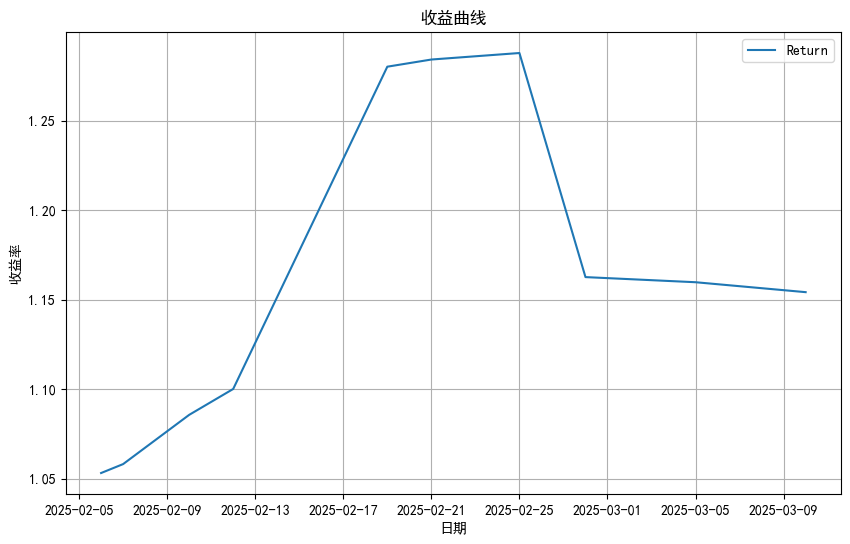

: 

In [ ]:
plot(ddwndx, 'cumulative_returns')

In [23]:
dwndx['r_pct'] = dwndx['real_open']/dwndx['open_price']

C:\Users\Administrator\AppData\Local\Temp\ipykernel_14296\2979096706.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dwndx['r_pct'] = dwndx['real_open']/dwndx['open_price']


In [24]:
pd.set_option('display.max_columns', None)
dwndx.sort_values(by='r_pct', ascending=False)

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,r_return,cumulative_returns,r_pct
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-01-23,1144,低吸,低位孕线低吸,600973.XSHG,宝胜股份,1,"000012.BKDL,000035.BKDL,000023.BKDL,000018.BKD...","885571.DDBK,885701.DDBK,886021.DDBK,886066.DDB...",980474.ZHBK,2,1,10,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,55.05,198.21,0.0,-1.57,5.00,4.90,-1.0,4.86,4.98,-1.0,-1.0,-1.0,-1.0,0,0,9G0086,低位孕线低吸,-4.82,-7.09,29,88.26,-3.17,2,2025-02-15 19:39:20,21423500.0,-0.028000,-0.029000,-0.004000,-0.005000,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,5.08,-0.020685,2.708991,1.016000
2025-01-21,1009,低吸,低位孕线低吸,002707.XSHE,众信旅游,1,"000012.BKDL,000003.BKDL,000038.BKDL,000026.BKD...","885694.DDBK,885788.DDBK,885757.DDBK,885990.DDB...","980336.ZHBK,980353.ZHBK,980473.ZHBK",2,2,56,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,39.03,185.63,0.0,-0.52,7.72,7.73,-1.0,7.78,7.58,-1.0,-1.0,-1.0,-1.0,0,0,9G0086,低位孕线低吸,5.29,-23.99,21,92.86,-9.38,2,2025-02-15 19:36:54,15070984.0,0.007772,0.006772,-0.018135,-0.019135,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,7.82,-0.031691,2.766210,1.012953
2025-03-05,722,低吸,低位孕线低吸,600391.XSHG,航发科技,2,"000018.BKDL,000037.BKDL,000017.BKDL,000013.BKD...","885520.DDBK,886021.DDBK,885795.DDBK,885595.DDB...",980363.ZHBK,3,6,39,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,67.31,243.78,0.0,-2.60,20.20,20.40,-1.0,20.41,20.25,-1.0,-1.0,-1.0,-1.0,0,0,9G0086,低位孕线低吸,-70.97,-17.17,42,79.86,-7.58,2,2025-03-06 08:01:25,20715100.0,0.010396,0.009396,0.002475,0.001475,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,20.44,-0.010295,2.742008,1.011881
2025-02-07,2365,低吸,低位孕线低吸,002579.XSHE,中京电子,2,"000015.BKDL,000019.BKDL,000034.BKDL,000013.BKD...","886042.DDBK,885875.DDBK,886009.DDBK,886070.DDB...",980357.ZHBK,1,1,14,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,93.10,286.69,0.0,-1.49,8.62,8.74,-1.0,8.76,8.81,-1.0,-1.0,-1.0,-1.0,0,0,9G0086,低位孕线低吸,89.42,-3.49,4,113.24,-5.90,2,2025-02-28 17:19:40,18323542.0,0.016241,0.015241,0.022042,0.021042,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,8.71,0.010481,2.850575,1.010441
2025-02-12,2567,低吸,低位孕线低吸,000712.XSHE,锦龙股份,1,"000038.BKDL,000015.BKDL,000031.BKDL","885620.DDBK,885694.DDBK,885570.DDBK,886050.DDB...","980360.ZHBK,980341.ZHBK",3,7,100,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,37.65,182.29,0.0,-2.03,14.50,15.08,-1.0,14.85,14.50,-1.0,-1.0,-1.0,-1.0,0,0,9G0086,低位孕线低吸,90.39,-2.92,8,118.67,-3.25,1,2025-02-28 17:22:29,30159710.0,0.024138,0.023138,0.000000,-0.001000,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,14.64,-0.010563,2.912930,1.009655
2025-01-16,811,低吸,低位孕线低吸,002757.XSHE,南兴股份,1,"000003.BKDL,000026.BKDL,000023.BKDL,000006.BKD...","885459.DDBK,885930.DDBK,885957.DDBK,885517.DDB...",980365.ZHBK,2,1,13,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,115.50,319.34,0.0,-3.24,15.55,15.42,-1.0,15.34,15.20,-1.0,-1.0,-1.0,-1.0,0,0,9G0086,低位孕线低吸,49.11,-22.10,7,119.41,-6.45,1,2025-02-1

<Axes: ylabel='Frequency'>

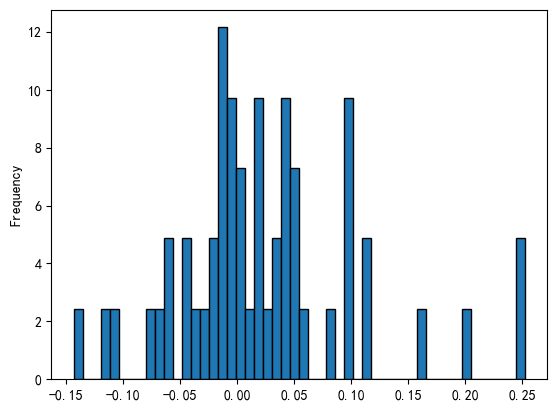

In [25]:
ddwndx['r_return'].plot(kind='hist', bins=50, density=True, edgecolor='black')

In [26]:
# 最大回撤: -14.59%
# 夏普比率: 0.29
# 总收益率: 234.78%
# 年化收益率: 722.40%
# 波动率: 5.95%
# 总盈亏: 235.83%
# 成功次数: 48
# 失败次数: 30
# 总天数: 78
# 总交易次数: 78
# 交易频率: 100.00%
# 胜率: 61.54%
# 平均盈利: 4.61%
# 平均亏损: -2.89%
# 最大盈利: 23.18%
# 最大亏损: -9.73%
# 盈亏比: 1.60
# 凯利公式最佳仓位: 37.43%

In [27]:
# return:
# 最大回撤: -14.59%
# 夏普比率: 0.28
# 总收益率: 192.71%
# 年化收益率: 690.29%
# 波动率: 6.32%
# 总盈亏: 194.90%
# 成功次数: 41
# 失败次数: 26
# 总天数: 67
# 总交易次数: 67
# 交易频率: 100.00%
# 胜率: 61.19%
# 平均盈利: 4.87%
# 平均亏损: -3.05%
# 最大盈利: 23.18%
# 最大亏损: -9.73%
# 盈亏比: 1.60
# 凯利公式最佳仓位: 36.91%

In [28]:
# return:
# 最大回撤: -14.83%
# 夏普比率: 0.31
# 总收益率: 192.83%
# 年化收益率: 784.38%
# 波动率: 6.57%
# 总盈亏: 195.02%
# 成功次数: 36
# 失败次数: 23
# 总天数: 59
# 总交易次数: 59
# 交易频率: 100.00%
# 胜率: 61.02%
# 平均盈利: 5.23%
# 平均亏损: -2.96%
# 最大盈利: 23.18%
# 最大亏损: -9.73%
# 盈亏比: 1.76
# 凯利公式最佳仓位: 38.92%
